In [61]:
!pip install aif360

  Using cached https://files.pythonhosted.org/packages/ff/7f/9d804d2348471c67a7d8b5f84f9bc59fd1cefa148986f2b74552f8573555/numpy-1.15.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: phik 0.9.8 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: mxnet 1.4.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.4 which is incompatible.
ERROR: mizani 0.5.4 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.21.2 which is incompatible.
ERROR: fbprophet 0.5 has requirement pandas>=0.

In [62]:
!pip install BlackBoxAuditing

In [63]:
!pip install numpy --upgrade

  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: phik 0.9.8 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: mxnet 1.4.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
ERROR: mizani 0.5.4 has requirement pandas>=0.23.4, but you'll have pandas 0.23.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.16.4 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, classification_report 
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

['hiring-prediction', 'hiring']


In [65]:
def confusion_matrix_plt(y_test_cm, y_pred_cm):
    y_test_legit = sum(y_test_cm==0)
    y_test_fraud = sum(y_test_cm==1)
    
    accuracy_cm = accuracy_score(y_test_cm, y_pred_cm)
    cfn_matrix = confusion_matrix(y_test_cm,y_pred_cm)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,annot=True,ax=ax)
    ax.set_title("Confusion Matrix \n Accuracy: %.2f%%" % (accuracy_cm * 100.0), fontsize=14)
    ax.set_xticklabels(['Rejected', 'Hired'], fontsize=10, rotation=90)
    ax.set_yticklabels(['Rejected', 'Hired'], fontsize=10, rotation=360)
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap=plt.cm.Blues,linewidths=0.5,annot=True,ax=ax)
    ax.set_title("Normalized Confusion Matrix \n Accuracy: %.2f%%" % (accuracy_cm * 100.0), fontsize=14)
    ax.set_xticklabels(['Rejected', 'Hired'], fontsize=10, rotation=90)
    ax.set_yticklabels(['Rejected', 'Hired'], fontsize=10, rotation=360)
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test_cm, y_pred_cm))

In [66]:
df = pd.read_csv('../input/hiring/hiring-dataset.csv')
training_df = pd.read_csv('../input/hiring-prediction/training_df.csv')
test_df = pd.read_csv('../input/hiring-prediction/test_df.csv')

In [67]:
protected_class = ['Unnamed: 0', 'Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Candidate Is Internal', 'Ethnicity Type', 'Candiate is disabled', 'Age (Years)',
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender', 'Hired']

X_train = training_df.drop(protected_class, axis=1)
y_train = training_df['Hired']
X_test = test_df.drop(protected_class, axis=1)
y_test = test_df['Hired']

In [68]:
lr_model = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [69]:
svc_model = SVC(kernel='linear', C=10, class_weight={0:1,1:60})
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

# Fairness Metrics
## Gender

In [70]:
def dataset_wrapper(outcome, protected, label, protected_attribute, unprivileged_groups, privileged_groups,
                          favorable_label, unfavorable_label):
    """ A wraper function to create aif360 dataset from outcome and protected in numpy array format.
    """
    df = pd.DataFrame(data=outcome,
                      columns=[label])
    df[protected_attribute] = protected
    
    dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=df,
                                label_names=[label],
                                protected_attribute_names=[protected_attribute],
                                unprivileged_protected_attributes=unprivileged_groups)
    return dataset

In [71]:
favorable_label = 1
unfavorable_label = 0


p_train = training_df['Candidate Gender']
p_test = test_df['Candidate Gender']
unprivileged_groups = [{'Candidate Gender': 0}]
privileged_groups = [{'Candidate Gender': 1}]

In [72]:
original_traning_dataset = dataset_wrapper(outcome=y_train, protected=p_train, 
                                         label='Hired', protected_attribute='Candidate Gender',
                                         unprivileged_groups=unprivileged_groups, 
                                         privileged_groups=privileged_groups,
                                         favorable_label=favorable_label,
                                         unfavorable_label=unfavorable_label)
original_test_dataset = dataset_wrapper(outcome=y_test, protected=p_test, 
                                        label='Hired', protected_attribute='Candidate Gender',
                                        unprivileged_groups=unprivileged_groups, 
                                        privileged_groups=privileged_groups,
                                        favorable_label=favorable_label,
                                        unfavorable_label=unfavorable_label)
plain_predictions_test_dataset_lr = dataset_wrapper(outcome=y_pred_lr, protected=p_test,
                                                 label='Hired', protected_attribute='Candidate Gender',
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                 unfavorable_label=unfavorable_label)
plain_predictions_test_dataset_svc = dataset_wrapper(outcome=y_pred_svc, protected=p_test,
                                                 label='Hired', protected_attribute='Candidate Gender',
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                 unfavorable_label=unfavorable_label)

In [73]:
def print_metrics(classified_metric, title):

    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)

    print(title)
    print("Test set: Classification accuracy = %f" % classified_metric.accuracy())
    print("Test set: Balanced classification accuracy = %f" % bal_acc)
    print("Test set: Statistical parity difference = %f" % classified_metric.statistical_parity_difference())
    print("Test set: Disparate impact = %f" % classified_metric.disparate_impact())
    print("Test set: Equal opportunity difference = %f" % classified_metric.equal_opportunity_difference())
    print("Test set: Average odds difference = %f" % classified_metric.average_odds_difference())
    print("Test set: Theil index = %f" % classified_metric.theil_index())
    print("Test set: False negative rate difference = %f" % classified_metric.false_negative_rate_difference())

In [74]:
classified_metric_nodebiasing_test_lr = ClassificationMetric(original_test_dataset,
                                         plain_predictions_test_dataset_lr,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
classified_metric_nodebiasing_test_svc = ClassificationMetric(original_test_dataset,
                                         plain_predictions_test_dataset_svc,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")

Plain LR model - without debiasing - classification metrics
Test set: Classification accuracy = 0.613567
Test set: Balanced classification accuracy = 0.578989
Test set: Statistical parity difference = -0.042147
Test set: Disparate impact = 0.895355
Test set: Equal opportunity difference = -0.197214
Test set: Average odds difference = -0.118851
Test set: Theil index = 0.066744
Test set: False negative rate difference = 0.197214

Plain SVM model - without debiasing - classification metrics
Test set: Classification accuracy = 0.565461
Test set: Balanced classification accuracy = 0.546808
Test set: Statistical parity difference = -0.009229
Test set: Disparate impact = 0.978942
Test set: Equal opportunity difference = -0.054985
Test set: Average odds difference = -0.031902
Test set: Theil index = 0.066509
Test set: False negative rate difference = 0.054985


In [75]:
def produce_metrics_dataframe(classifier, algorithm, classified_metric):
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    results = {'Classifier': classifier,
            'Algorithm': algorithm,
            'Classification accuracy': classified_metric.accuracy(),
            'Balanced classification accuracy': bal_acc, 
            'Statistical parity difference': classified_metric.statistical_parity_difference(),
            'Disparate impact': classified_metric.disparate_impact(),
            'Equal opportunity difference': classified_metric.equal_opportunity_difference(),
            'Average odds difference': classified_metric.average_odds_difference(),
            'Theil index': classified_metric.theil_index(),
            'False negative rate difference': classified_metric.false_negative_rate_difference()
            }
    return results

results_lr = produce_metrics_dataframe('LR', '/', classified_metric_nodebiasing_test_lr)
results_svc = produce_metrics_dataframe('SVM', '/', classified_metric_nodebiasing_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df_lr, results_df_svc],ignore_index = True)

# Preprocessing Algorithms
## Reweighing
Reweighing is a preprocessing technique that weights the examples in each (group, label) combination differently to ensure fairness before classification. 

In [76]:
from aif360.algorithms.preprocessing import Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(original_traning_dataset)
transf_traning_dataset = RW.transform(original_traning_dataset)

In [77]:
metric_orig_train = BinaryLabelDatasetMetric(original_traning_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_tranf_train = BinaryLabelDatasetMetric(transf_traning_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original training dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())
print("Transformed training dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_tranf_train.mean_difference())

Original training dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.002478
Transformed training dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.000000


In [78]:
metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original testing dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
print("Transformed testing dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())

Original testing dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.002858
Transformed testing dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.000495


In [79]:
pd.DataFrame({'Candidate Gender': p_train,
              'Hired': y_train,
              'Original_weight': np.ones(shape=(y_train.shape[0],)),
              'new_weight': transf_traning_dataset.instance_weights}).sample(15)

,Candidate Gender,Hired,Original_weight,new_weight
14690,1,0,1.0,0.996909
17576,1,0,1.0,0.996909
9316,1,0,1.0,0.996909
4948,1,0,1.0,0.996909
4195,1,0,1.0,0.996909
4982,1,0,1.0,0.996909
7266,1,0,1.0,0.996909
492,1,0,1.0,0.996909
16754,0,0,1.0,0.999418
2248,1,0,1.0,0.996909


In [80]:
unbiased_lr = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
unbiased_lr.fit(X_train, y_train, sample_weight=transf_traning_dataset.instance_weights)
    
y_pred_transf_lr = unbiased_lr.predict(X_test)

In [81]:
unbiased_svc = SVC(kernel='linear', C=10, class_weight={0:1,1:60})
unbiased_svc.fit(X_train, y_train, sample_weight=transf_traning_dataset.instance_weights)
    
y_pred_transf_svc = unbiased_svc.predict(X_test)

In [82]:
transf_predictions_test_dataset_lr = dataset_wrapper(outcome=y_pred_transf_lr, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )
transf_predictions_test_dataset_svc = dataset_wrapper(outcome=y_pred_transf_svc, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )

classified_metric_reweighing_test_lr = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_reweighing_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


In [83]:
print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_reweighing_test_lr, "LR model - with reweighing - classification metrics")
print('')
print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_reweighing_test_svc, "SVM model - with reweighing - classification metrics")

Plain LR model - without debiasing - classification metrics
Test set: Classification accuracy = 0.613567
Test set: Balanced classification accuracy = 0.578989
Test set: Statistical parity difference = -0.042147
Test set: Disparate impact = 0.895355
Test set: Equal opportunity difference = -0.197214
Test set: Average odds difference = -0.118851
Test set: Theil index = 0.066744
Test set: False negative rate difference = 0.197214

LR model - with reweighing - classification metrics
Test set: Classification accuracy = 0.425161
Test set: Balanced classification accuracy = 0.553059
Test set: Statistical parity difference = -0.032460
Test set: Disparate impact = 0.945138
Test set: Equal opportunity difference = -0.180352
Test set: Average odds difference = -0.105495
Test set: Theil index = 0.056905
Test set: False negative rate difference = 0.180352

Plain SVM model - without debiasing - classification metrics
Test set: Classification accuracy = 0.565461
Test set: Balanced classification accu

Accuracy:


,LogReg
Unfair,0.613567
Fair,0.425161


AUC:


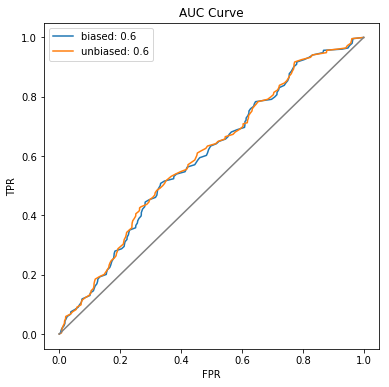

In [84]:
from typing import List, Union, Dict

def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
    
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)

print('Accuracy:')
display(pd.DataFrame({'LogReg': [lr_model.score(X_test, y_test), 
                                 unbiased_lr.score(X_test, y_test)]}, 
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_auc(y_test, 
         {'biased': lr_model.predict_proba(X_test)[:, 1],
          'unbiased': unbiased_lr.predict_proba(X_test)[:, 1]},
         title='AUC Curve') 
plt.show()

In [85]:
results_lr = produce_metrics_dataframe('LR', 'Reweighing', classified_metric_reweighing_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Reweighing', classified_metric_reweighing_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

## Disparate Impact Remover
Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups

In [86]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

DIR = DisparateImpactRemover()
transf_traning_dataset = DIR.fit_transform(original_traning_dataset)
transf_test_dataset = DIR.fit_transform(original_test_dataset)

In [87]:
X_tr = transf_traning_dataset.features
X_te = transf_test_dataset.features
y_tr = transf_traning_dataset.labels.ravel()

unbiased_lr = LogisticRegression(penalty='l1', C=0.01, class_weight={0:1,1:60})
unbiased_lr.fit(X_tr, y_tr)

y_pred_transf_lr = unbiased_lr.predict(X_te)

transf_predictions_test_dataset_lr = dataset_wrapper(outcome=y_pred_transf_lr, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )
classified_metric_dir_test_lr = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [88]:
unbiased_svc = SVC(kernel='linear', C=10, class_weight={0:1,1:60})
unbiased_svc.fit(X_tr, y_tr)
    
y_pred_transf_svc = unbiased_svc.predict(X_te)

transf_predictions_test_dataset_svc = dataset_wrapper(outcome=y_pred_transf_svc, protected=p_test,
                                                  label='Hired', protected_attribute='Candidate Gender',
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )
classified_metric_dir_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [89]:
print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_dir_test_lr, "LR model - with Disparate Impact Remover - classification metrics")
print('')
print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_dir_test_svc, "SVM model - with Disparate Impact Remover - classification metrics")
print('')

Plain LR model - without debiasing - classification metrics
Test set: Classification accuracy = 0.613567
Test set: Balanced classification accuracy = 0.578989
Test set: Statistical parity difference = -0.042147
Test set: Disparate impact = 0.895355
Test set: Equal opportunity difference = -0.197214
Test set: Average odds difference = -0.118851
Test set: Theil index = 0.066744
Test set: False negative rate difference = 0.197214

LR model - with Disparate Impact Remover - classification metrics
Test set: Classification accuracy = 0.367799
Test set: Balanced classification accuracy = 0.508427
Test set: Statistical parity difference = -1.000000
Test set: Disparate impact = 0.000000
Test set: Equal opportunity difference = -1.000000
Test set: Average odds difference = -1.000000
Test set: Theil index = 0.052580
Test set: False negative rate difference = 1.000000

Plain SVM model - without debiasing - classification metrics
Test set: Classification accuracy = 0.565461
Test set: Balanced class

In [90]:
results_lr = produce_metrics_dataframe('LR', 'Disparate Impact Remover', classified_metric_dir_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Disparate Impact Remover', classified_metric_dir_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

## Learning Fair Representations
Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.

运行有问题

In [91]:
from aif360.algorithms.preprocessing import LFR

FR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=unprivileged_groups)
FR = FR.fit(original_traning_dataset)
transf_traning_dataset = FR.transform(original_traning_dataset)

LoweringError: Failed in object mode pipeline (step: object mode frontend)
Failed in object mode pipeline (step: object mode backend)
[1m[1m(<class 'numba.ir.Print'>, <numba.ir.Print object at 0x7fdf29311b00>)
[1m
File "../../opt/conda/lib/python3.6/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py", line 104:[0m
[1mdef LFR_optim_obj(params, data_sensitive, data_nonsensitive, y_sensitive,
    <source elided>
    if LFR_optim_obj.iters % print_inteval == 0:
[1m        print(LFR_optim_obj.iters, criterion)
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: lowering "print($392.3, criterion)" at /opt/conda/lib/python3.6/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py (104)[0m
-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!



## Optimized Preprocessing
Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives

需要distortion function

In [92]:
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

optim_options = {
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)
OP.fit(original_traning_dataset)
transf_traning_dataset = OP.transform(original_traning_dataset)
transf_test_dataset = OP.transform(original_test_dataset)

KeyError: 'distortion_fun'

# Inprocessing Algorithms
## Adversarial Debiasing
Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions 

In [93]:
from aif360.algorithms.inprocessing import AdversarialDebiasing
tf.reset_default_graph()

AD = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                          privileged_groups=privileged_groups,
                          scope_name="AD_LR", sess=tf.Session()) 
AD.fit(original_traning_dataset)
y_pred_AD = AD.predict(original_test_dataset)

epoch 0; iter: 0; batch classifier loss: 0.746407; batch adversarial loss: 0.744860
epoch 1; iter: 0; batch classifier loss: 0.982791; batch adversarial loss: 0.723262
epoch 2; iter: 0; batch classifier loss: 0.581721; batch adversarial loss: 0.677080
epoch 3; iter: 0; batch classifier loss: 0.225721; batch adversarial loss: 0.647984
epoch 4; iter: 0; batch classifier loss: 0.138737; batch adversarial loss: 0.636121
epoch 5; iter: 0; batch classifier loss: 0.121539; batch adversarial loss: 0.652006
epoch 6; iter: 0; batch classifier loss: 0.087841; batch adversarial loss: 0.634998
epoch 7; iter: 0; batch classifier loss: 0.113981; batch adversarial loss: 0.673581
epoch 8; iter: 0; batch classifier loss: 0.040903; batch adversarial loss: 0.657542
epoch 9; iter: 0; batch classifier loss: 0.088726; batch adversarial loss: 0.630952
epoch 10; iter: 0; batch classifier loss: 0.088980; batch adversarial loss: 0.662175
epoch 11; iter: 0; batch classifier loss: 0.028252; batch adversarial loss:

In [94]:
tf.reset_default_graph()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=tf.Session())
plain_model.fit(original_traning_dataset)
y_pred_plain = plain_model.predict(original_test_dataset)

epoch 0; iter: 0; batch classifier loss: 0.676897
epoch 1; iter: 0; batch classifier loss: 0.168262
epoch 2; iter: 0; batch classifier loss: 0.034499
epoch 3; iter: 0; batch classifier loss: 0.195817
epoch 4; iter: 0; batch classifier loss: 0.163185
epoch 5; iter: 0; batch classifier loss: 0.052942
epoch 6; iter: 0; batch classifier loss: 0.016479
epoch 7; iter: 0; batch classifier loss: 0.084846
epoch 8; iter: 0; batch classifier loss: 0.047577
epoch 9; iter: 0; batch classifier loss: 0.081227
epoch 10; iter: 0; batch classifier loss: 0.084418
epoch 11; iter: 0; batch classifier loss: 0.015331
epoch 12; iter: 0; batch classifier loss: 0.042845
epoch 13; iter: 0; batch classifier loss: 0.078038
epoch 14; iter: 0; batch classifier loss: 0.051941
epoch 15; iter: 0; batch classifier loss: 0.110274
epoch 16; iter: 0; batch classifier loss: 0.059394
epoch 17; iter: 0; batch classifier loss: 0.057156
epoch 18; iter: 0; batch classifier loss: 0.145659
epoch 19; iter: 0; batch classifier loss:

In [95]:
classified_metric_noadversarialdebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 y_pred_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_adversarialdebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 y_pred_AD,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print_metrics(classified_metric_noadversarialdebiasing_test, "Plain model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_adversarialdebiasing_test, "model - with adversarial debiasing - classification metrics")

Plain model - without debiasing - classification metrics
Test set: Classification accuracy = 0.987090
Test set: Balanced classification accuracy = 0.582677
Test set: Statistical parity difference = 0.000000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil index = 0.012994
Test set: False negative rate difference = 0.000000

model - with adversarial debiasing - classification metrics
Test set: Classification accuracy = 0.984533
Test set: Balanced classification accuracy = 0.500000
Test set: Statistical parity difference = 0.000000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil index = 0.015588
Test set: False negative rate difference = 0.000000


In [96]:
results_plain = produce_metrics_dataframe('/', 'no Adversarial Debiasing', classified_metric_noadversarialdebiasing_test)
results_ad = produce_metrics_dataframe('/', 'Adversarial Debiasing', classified_metric_noadversarialdebiasing_test)
results_df_plain pd.DataFrame(results_lr, index = [0])
results_df_ad pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

SyntaxError: invalid syntax (<ipython-input-96-14ad5466cc34>, line 3)

## ART Classifier

In [ ]:
from aif360.algorithms.inprocessing import ARTClassifier

ART = ARTClassifier(art_classifier)
AD.fit(original_traning_dataset)
y_pred_AD = AD.predict(original_test_dataset)

## Prejudice Remover
Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

In [ ]:
from aif360.algorithms.inprocessing import PrejudiceRemover

PR = PrejudiceRemover(sensitive_attr='Candidate Gender', class_attr='Hired')
PR.fit(original_training_dataset)
y_pred_PR = PR.predict(original_test_dataset)

# Postprocessing Algorithms
## Equality of Odds
Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds

In [ ]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

pos_ind = np.where(lr_model.classes_ == original_traning_dataset.favorable_label)[0][0]
dataset_orig_test_pred_lr = original_test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_lr.scores = lr_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

EOP_lr = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
EOP_lr.fit(original_test_dataset, dataset_orig_test_pred_lr)
y_pred_EOP_lr = EOP_lr.predict(dataset_orig_test_pred_lr)

# pos_ind = np.where(svc_model.classes_ == original_traning_dataset.favorable_label)[0][0]
# dataset_orig_test_pred_svc = original_test_dataset.copy(deepcopy=True)
# dataset_orig_test_pred_svc.scores = svc_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

# EOP_svc = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# EOP_svc.fit(original_test_dataset, dataset_orig_test_pred_svc)
# y_pred_EOP_svc = EOP_svc.predict(dataset_orig_test_pred_svc)

In [ ]:
classified_metric_eqodds_test_lr = ClassificationMetric(original_test_dataset, 
                                                 y_pred_EOP_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
# classified_metric_eqodds_test_svc = ClassificationMetric(original_test_dataset, 
#                                                  y_pred_EOP_svc,
#                                                  unprivileged_groups=unprivileged_groups,
#                                                  privileged_groups=privileged_groups)

print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_eqodds_test_lr, "LR model - with Equalized Odds - classification metrics")
print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_eqodds_test_svc, "SVM model - with Equalized Odds - classification metrics")

In [ ]:
results_lr = produce_metrics_dataframe('LR', 'Equalized Odds', classified_metric_eqodds_test_lr)
# results_svc = produce_metrics_dataframe('SVM', 'Equalized Odds', classified_metric_eqodds_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
# results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr],ignore_index = True)

## Calibrated Equality of Odds
Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective

In [ ]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

pos_ind = np.where(lr_model.classes_ == original_traning_dataset.favorable_label)[0][0]
dataset_orig_test_pred_lr = original_test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_lr.scores = lr_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

CEOP_lr = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
CEOP_lr.fit(original_test_dataset, dataset_orig_test_pred_lr)
y_pred_CEOP_lr = CEOP_lr.predict(dataset_orig_test_pred_lr)

# pos_ind = np.where(svc_model.classes_ == original_traning_dataset.favorable_label)[0][0]
# dataset_orig_test_pred_svc = original_test_dataset.copy(deepcopy=True)
# dataset_orig_test_pred_svc.scores = svc_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

# CEOP_svc = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# CEOP_svc.fit(original_test_dataset, dataset_orig_test_pred_svc)
# y_pred_CEOP_svc = CEOP_svc.predict(dataset_orig_test_pred_svc)

In [ ]:
classified_metric_ceqodds_test_lr = ClassificationMetric(original_test_dataset, 
                                                 y_pred_CEOP_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
# classified_metric_ceqodds_test_svc = ClassificationMetric(original_test_dataset, 
#                                                  y_pred_CEOP_svc,
#                                                  unprivileged_groups=unprivileged_groups,
#                                                  privileged_groups=privileged_groups)

print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_ceqodds_test_lr, "LR model - with Calibrated Equalized Odds - classification metrics")
print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_ceqodds_test_svc, "SVM model - with Calibrated Equalized Odds - classification metrics")

In [ ]:
results_lr = produce_metrics_dataframe('LR', 'Calibrated Equalized Odds', classified_metric_ceqodds_test_lr)
# results_svc = produce_metrics_dataframe('SVM', 'Calibrated Equalized Odds', classified_metric_ceqodds_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
# results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr],ignore_index = True)

## Reject Option Classification
Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [ ]:
from aif360.algorithms.postprocessing import RejectOptionClassification

pos_ind = np.where(lr_model.classes_ == original_traning_dataset.favorable_label)[0][0]
dataset_orig_test_pred_lr = original_test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_lr.scores = lr_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

ROC_lr = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
ROC_lr.fit(original_test_dataset, dataset_orig_test_pred_lr)
y_pred_ROC_lr = ROC_lr.predict(dataset_orig_test_pred_lr)

# pos_ind = np.where(svc_model.classes_ == original_traning_dataset.favorable_label)[0][0]
# dataset_orig_test_pred_svc = original_test_dataset.copy(deepcopy=True)
# dataset_orig_test_pred_svc.scores = svc_model.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

# ROC_svc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# ROC_svc.fit(original_test_dataset, dataset_orig_test_pred_svc)
# y_pred_ROC_svc = ROC_svc.predict(dataset_orig_test_pred_svc)

In [ ]:
classified_metric_roc_test_lr = ClassificationMetric(original_test_dataset, 
                                                 y_pred_ROC_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
# classified_metric_roc_test_svc = ClassificationMetric(original_test_dataset, 
#                                                  y_pred_ROC_svc,
#                                                  unprivileged_groups=unprivileged_groups,
#                                                  privileged_groups=privileged_groups)

print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_roc_test_lr, "LR model - with Reject Option Classification - classification metrics")
print('')
# print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
# print('')
# print_metrics(classified_metric_roc_test_svc, "SVM model - with Reject Option Classification - classification metrics")

In [ ]:
results_lr = produce_metrics_dataframe('LR', 'Reject Option Classification', classified_metric_roc_test_lr)
# results_svc = produce_metrics_dataframe('SVM', 'Reject Option Classification', classified_metric_roc_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
# results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr],ignore_index = True)

In [ ]:
results_df = results_df.drop([9, 10, 11, 12, 13, 14, 15, 16])
results_df

# 观察一个方面的fairness降低会不会对另一个方面产生影响

In [ ]:
print(training_df.groupby(['Ethnicity Type'])['Hired'].mean())
print('')
print(training_df['Ethnicity Type'].value_counts())

In [ ]:
new_unprivileged_groups = [{'Ethnicity Type': [2, 3, 4, 5, 6]}]
new_privileged_groups = [{'Ethnicity Type': 1}]
p_train = training_df['Ethnicity Type']
p_test = test_df['Ethnicity Type']

In [ ]:
original_traning_dataset = dataset_wrapper(outcome=y_train, protected=p_train, 
                                         label='Hired', protected_attribute='Ethnicity Type',
                                         unprivileged_groups=new_unprivileged_groups, 
                                         privileged_groups=new_privileged_groups,
                                         favorable_label=favorable_label,
                                         unfavorable_label=unfavorable_label)
original_test_dataset = dataset_wrapper(outcome=y_test, protected=p_test, 
                                        label='Hired', protected_attribute='Ethnicity Type',
                                        unprivileged_groups=new_unprivileged_groups, 
                                        privileged_groups=new_privileged_groups,
                                        favorable_label=favorable_label,
                                        unfavorable_label=unfavorable_label)
plain_predictions_test_dataset = dataset_wrapper(outcome=y_pred_lr, protected=p_test,
                                                 label='Hired', protected_attribute='Ethnicity Type',
                                                 unprivileged_groups=new_unprivileged_groups,
                                                 privileged_groups=new_privileged_groups,
                                                 favorable_label=favorable_label,
                                                 unfavorable_label=unfavorable_label)

In [ ]:
classified_metric_debiasing_test = ClassificationMetric(original_test_dataset, 
                                                 y_pred_EOP,
                                                 unprivileged_groups=new_unprivileged_groups,
                                                 privileged_groups=new_privileged_groups)
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)

print("Plain model - without debiasing - classification metrics")
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_nodebiasing_test.false_negative_rate_difference())

print('')
print("Model - with debiasing - classification metrics")
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_debiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_debiasing_test.false_negative_rate_difference())